# Imports

In [59]:
import os
import re
import gif
import json
import tqdm
import geopy
import warnings
import requests
import community

import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from IPython.display import Image
from tqdm import tqdm

from pre_process_baci import pre_process_data

warnings.filterwarnings('ignore')

# Functions

In [3]:
def infectRandomGuy(G, GC):
    random_guy = np.random.choice(GC.nodes())
    G.nodes[random_guy]['Infected'] = True
    print(f'{random_guy} has been infected.')


def oneStep(G, beta):
    infecteds = [n[0] for n in G.nodes(data=True) if n[1]['Infected']]
    [G.nodes[neighbor].update({'Infected': True}) 
     for infected in infecteds 
     for neighbor in G.neighbors(infected)
     if np.random.binomial(1, p=beta)
    ]

def basicNetStats(graph_dict):
    data = []
    for k, v in graph_dict.items():
        data_dict = {
            '$N$': v.number_of_nodes(),
            '$L$': v.number_of_edges(),
            '$C$': (nx.average_clustering(v)
                    if type(v) == nx.classes.graph.Graph
                    else 'multigraph'),
            '$l$': (nx.average_shortest_path_length(v)),
            '$\left\langle k \right\rangle$': np.mean(list(dict(v.degree()).values()))
        }
        data.append(data_dict)
    return pd.DataFrame(data, index=graph_dict.keys())

class randomGraphModel:
    def __init__(self, method, **kwargs):
        self.N = kwargs['N']
        LMax = [(x, y) for x in range(self.N)
                for y in range(x + 1, self.N)]
        if method == 'GNp':
            self.p = kwargs['p']
            self.edges = [L for L in tqdm.tqdm(LMax)
                          if np.random.binomial(1, self.p)]
        if method == 'GNL':
            self.L = kwargs['L']
            self.edges = [LMax[i] for i in
                          np.random.choice(len(LMax), self.L, replace=False)]
        clear_output(wait=True)

    def plotDist(self):
        ks = Counter([node for edge in self.edges for node in edge])
        sns.displot(ks.values(), kde=True, legend=False)
        plt.title(f'Total Edges = {len(self.edges):,}')


def configurationModel(G=None, N=None, gamma=None, deg_seq=None, seed=None):
    if N and gamma:
        deg_seq = [
            int(i) for i in nx.utils.powerlaw_sequence(N, gamma, seed=seed)]
        deg_seq[0] += 1 if sum(deg_seq) % 2 else 0
    elif deg_seq:
        pass
    elif G:
        deg_seq = [deg for _, deg in G.degree()]
    else:
        raise ValueError('Missing parameters')
    return {
        'G': nx.configuration_model(deg_seq, seed=seed),
        'degree_sequence': deg_seq}


def hiddenParameterModel(G=None, N=None, gamma=None, deg_seq=None, seed=None):
    if N and gamma:
        deg_seq = nx.utils.powerlaw_sequence(N, gamma, seed=seed)
    elif deg_seq:
        pass
    elif G:
        deg_seq = [deg for _, deg in G.degree()]
    else:
        raise ValueError('Missing parameters')
    return {
        'G': nx.expected_degree_graph(
            deg_seq, seed=seed, selfloops=False),
        'degree_sequence': deg_seq}


def degreePreservingModel(G, seed=None):
    return {
        'G': nx.random_reference(G, connectivity=True, seed=seed),
        'pos': nx.kamada_kawai_layout(G),
        'degree_sequence': [deg for _, deg in G.degree()]}

def basicPlotGraph(G, pos=None, degree_sequence=None):
    pos = pos if pos else nx.kamada_kawai_layout(G)
    fig, ax = plt.subplots(figsize=(15, 7), ncols=2)
    nx.draw_networkx_nodes(G, pos, node_size=100, alpha=0.5, ax=ax[0])
    nx.draw_networkx_edges(G, pos, ax=ax[0])
    nx.draw_networkx_labels(G, pos, font_color='black', ax=ax[0])
    ax[1].hist([deg for _, deg in G.degree()], bins=20)
    plt.tight_layout()

# Load the Data

In [4]:
data_dictio = pre_process_data('datasets')

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Start reading files...


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:16<00:00,  9.57s/it]


Reading files completed...
Start getting Country Code and HS Codes online...


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Getting Country Code and HS Codes online completed...
Start mapping Country Code and HS Codes to each df...


 12%|██████████▌                                                                         | 1/8 [00:00<00:02,  3.45it/s]

Mapping Country Code and HS Codes to each df completed...
Start getting Lat/long for each country...


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.69s/it]


Mapping lat/long for each country in df completed...


# Network Properties/Topolgy across the Years

In [11]:
df = pd.read_csv('datasets2/DOT_04-08-2021 13-14-10-97_panel.csv', 
                 low_memory=False)
imf_code = pd.read_excel('datasets2/co.xlsx', header=1)['IMF Code']
df = df.loc[df['Country Code'].isin(imf_code)]
df = df.loc[df['Counterpart Country Code'].isin(imf_code)]

In [12]:
df.head()

,Country Name,Country Code,Counterpart Country Name,Counterpart Country Code,Time Period,"Goods, Value of Exports, Free on board (FOB), US Dollars (TXG_FOB_USD)",Status,"Goods, Value of Imports, Cost, Insurance, Freight (CIF), US Dollars (TMG_CIF_USD)",Status.1,"Goods, Value of Imports, Free on board (FOB), US Dollars (TMG_FOB_USD)",Status.2,"Goods, Value of Trade Balance, US Dollars (TBG_USD)",Status.3,Unnamed: 13
0,Argentina,213,United States,111,1948,159100000.0,NaN,604000000.0,NaN,NaN,NaN,-444900000.0,NaN,NaN
1,Argentina,213,United States,111,1952,161500000.0,NaN,229900000.0,NaN,NaN,NaN,-68400000.0,NaN,NaN
2,Argentina,213,United States,111,1953,181300000.0,NaN,123900000.0,NaN,NaN,NaN,57400000.0,NaN,NaN
3,Argentina,213,United States,111,1954,122400000.0,NaN,141200000.0,NaN,NaN,NaN,-18800000.0,NaN,NaN
4,Argentina,213,United States,111,1955,118300000.0,NaN,154300000.0,NaN,NaN,NaN,-36000000.0,NaN,NaN


In [ ]:
for graph in 
OG = nx.convert_matrix.from_pandas_edgelist(
          df_2019, source='exporter', target='importer', 
          create_using=nx.DiGraph(), edge_attr=['hs_sec', 'value_kUSD', 
                                                'quantity_mtons', 
                                                'exp_coord', 'exp_coord'])

In [20]:
props = pd.DataFrame()
df1 = df.groupby('Time Period')
year_list = df['Time Period'].unique()

for OG in tqdm(range(len(year_list))):
    G = nx.convert_matrix.from_pandas_edgelist(
         df1.get_group(year_list[OG]), source='Country Name', 
         target='Counterpart Country Name')
    stats = basicNetStats({f'{year_list[OG]}': G})
    props = pd.concat([props, stats])

100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [01:06<00:00,  1.09it/s]


In [146]:
props = props.sort_index()
props.head(10)

,$N$,$L$,$C$,$l$,$\left\langle k \right\rangle$
1948,87,1862,0.796131,1.502272,42.804598
1949,84,1720,0.781285,1.506598,40.952381
1950,86,1799,0.780857,1.507798,41.837209
1951,109,1903,0.644541,1.690962,34.917431
1952,89,2103,0.788892,1.463483,47.258427
1953,90,2165,0.778825,1.459675,48.111111
1954,91,2105,0.771032,1.519414,46.263736
1955,95,2262,0.784431,1.495633,47.621053
1956,94,2343,0.800183,1.463967,49.851064
1957,97,2302,0.764833,1.517397,47.463918


No handles with labels found to put in legend.


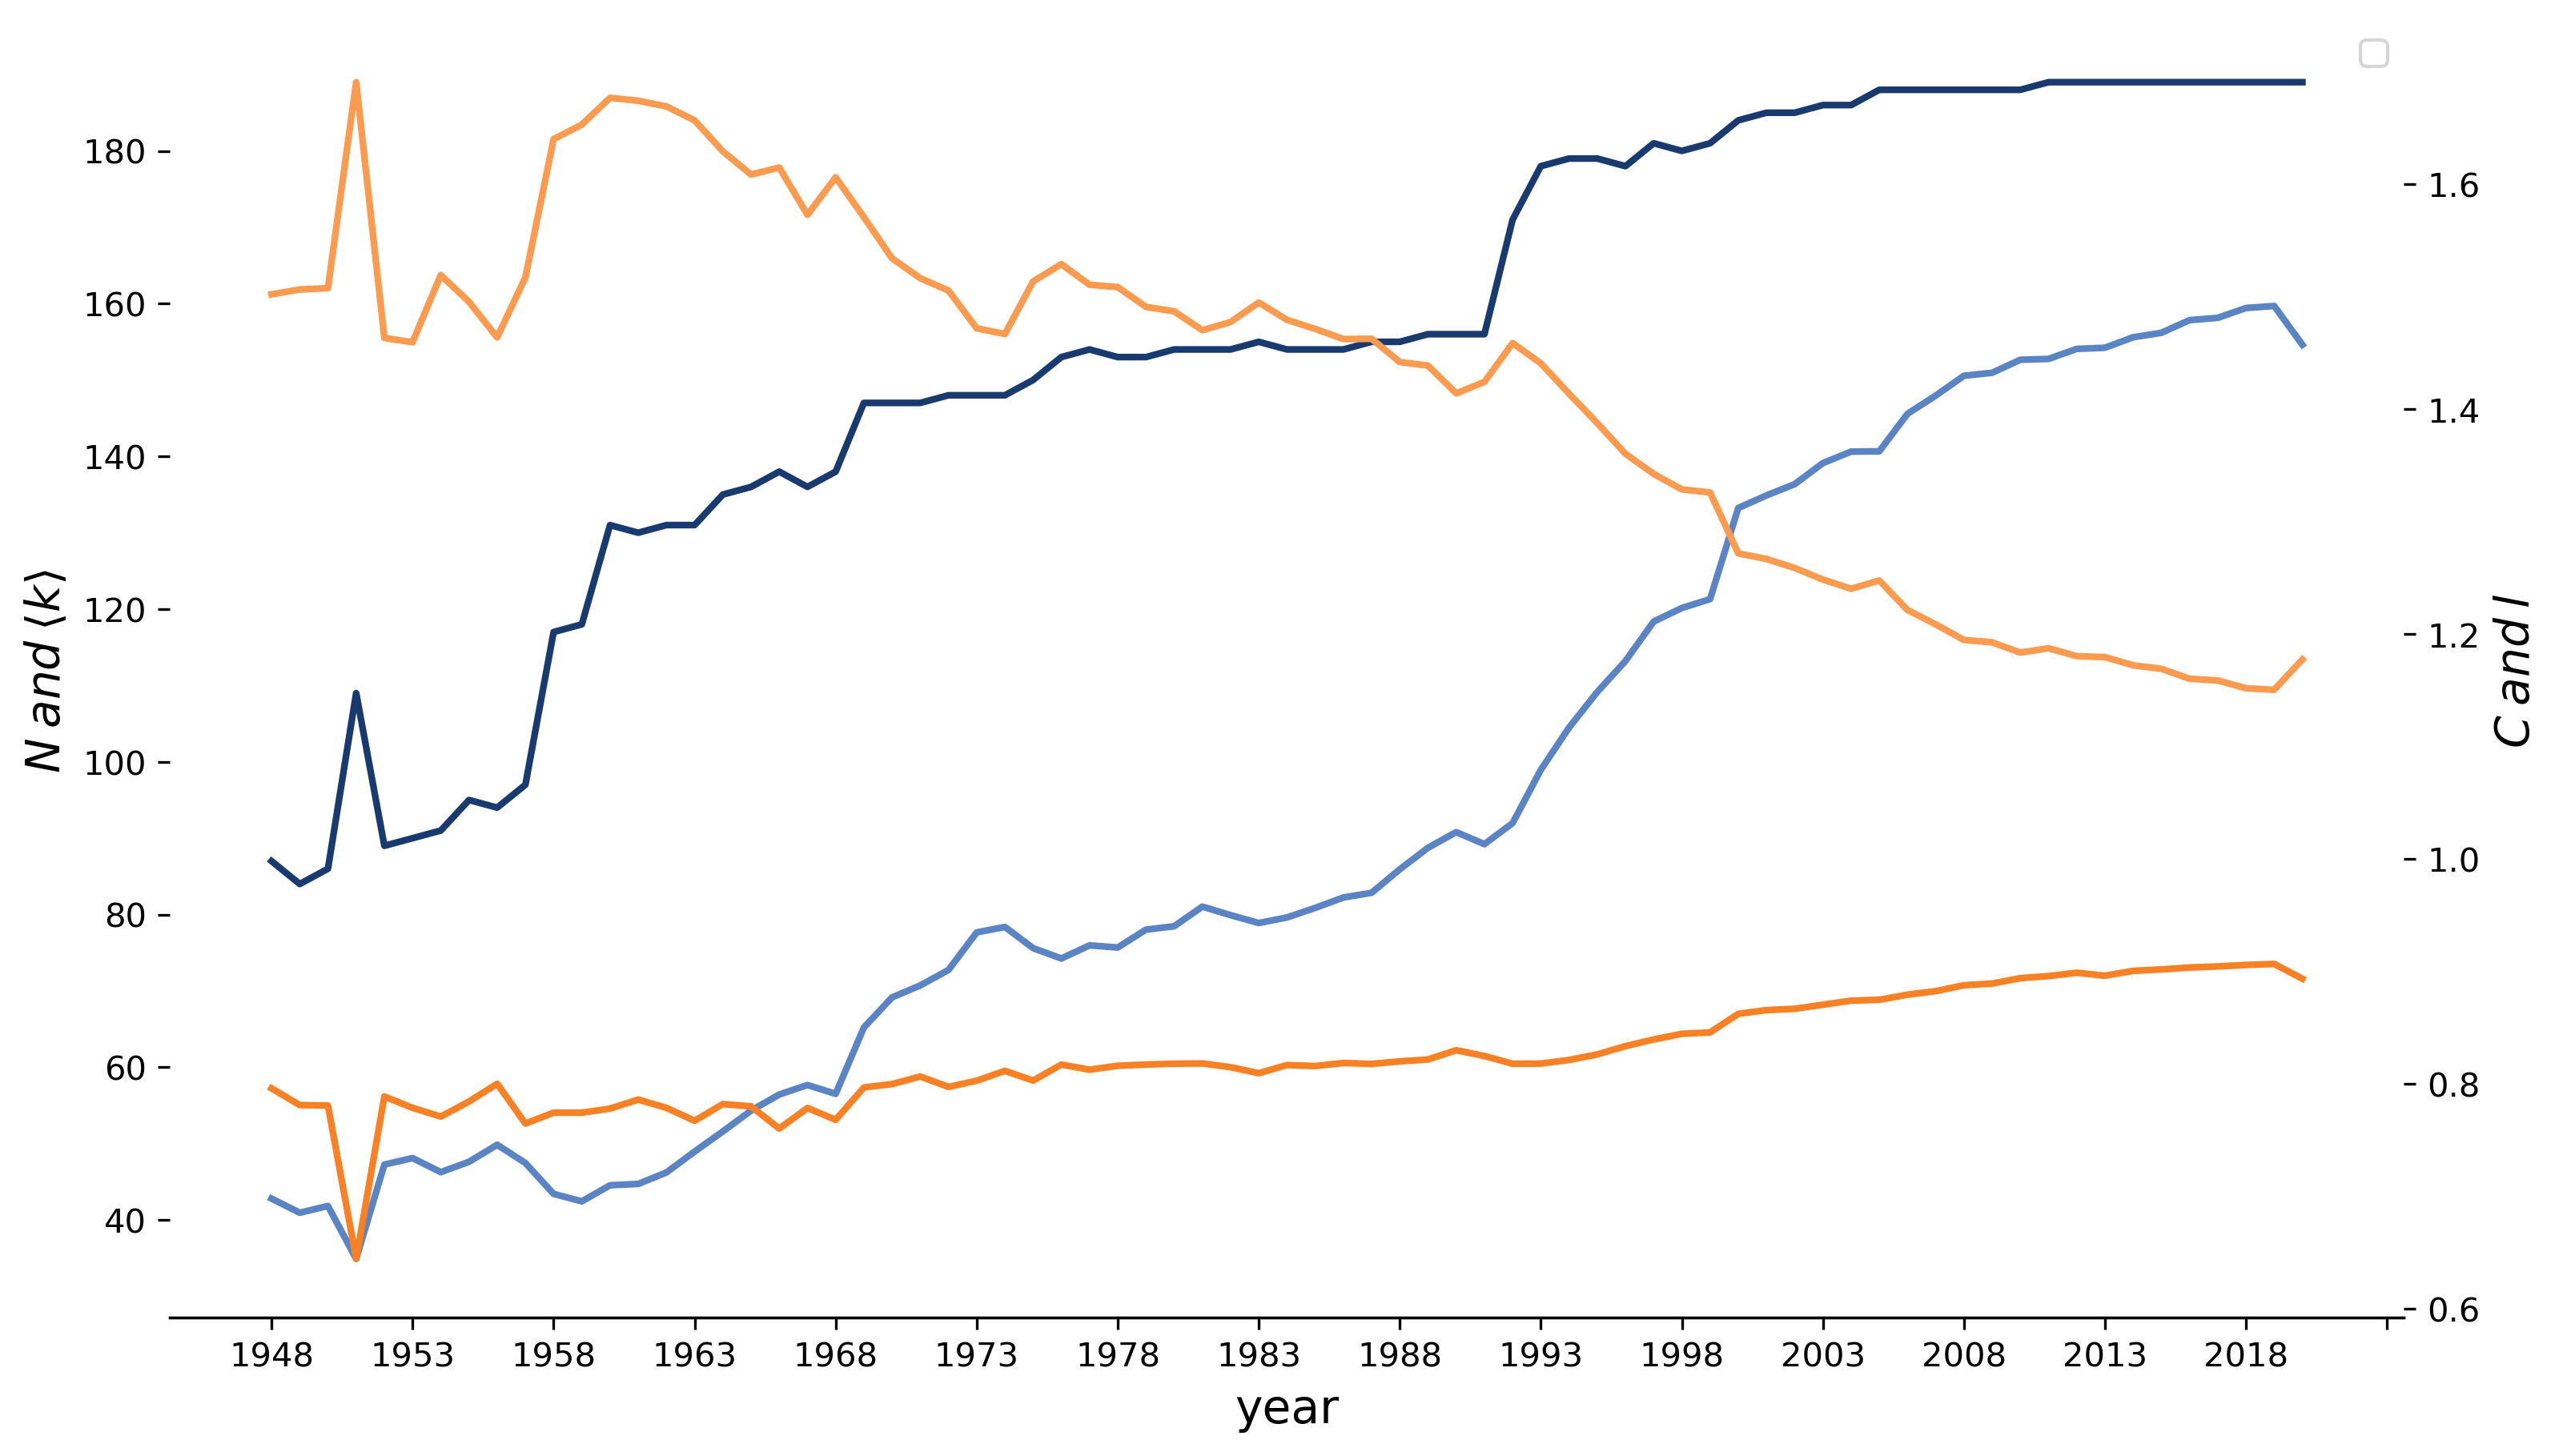

In [83]:
import matplotlib.ticker as plticker

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(12,7), dpi=300)
# make a plot
ax.plot(props.index, props['$N$'], color="#193A6F", linewidth=2)
ax.plot(props.index, props['$\left\langle k \right\rangle$'], 
             color="#5B84C4", linewidth=2)
# set x-axis label
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel(r"$N\: and\: \left\langle k \right\rangle$",fontsize=14)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(props.index, props["$C$"], color="#F98125", linewidth=2)
ax2.plot(props.index, props["$l$"], color="#FB9B50", linewidth=2)
ax2.set_ylabel(r"$C\: and\: l$",fontsize=14)
sns.despine(left=True)
loc = plticker.MultipleLocator(base=5) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax2.xaxis.set_major_locator(loc)
ax.legend()
plt.show();


## No. of Nodes, Edges, Clustering Coefficient, and Ave Shortest Path Length

In [99]:
#list_of_dfs = [df_2012, df_2013, df_2014, df_2015, df_2016, 
#               df_2017, df_2018, df_2019]
#
#OG_2012 = nx.convert_matrix.from_pandas_edgelist(
#          data_dictio['Y2012'], source='exporter', target='importer', 
#          create_using=nx.DiGraph(), edge_attr=['hs_sec', 'value_kUSD', 
#                                                'quantity_mtons', 
#                                                'exp_coord', 'exp_coord'])
#OG_2013 = nx.convert_matrix.from_pandas_edgelist(
#          data_dictio['Y2013'], source='exporter', target='importer', 
#          create_using=nx.DiGraph(), edge_attr=['hs_sec', 'value_kUSD', 
#                                                'quantity_mtons', 
#                                                'exp_coord', 'exp_coord'])
#OG_2014 = nx.convert_matrix.from_pandas_edgelist(
#          data_dictio['Y2014'], source='exporter', target='importer', 
#          create_using=nx.DiGraph(), edge_attr=['hs_sec', 'value_kUSD', 
#                                                'quantity_mtons', 
#                                                'exp_coord', 'exp_coord'])
#OG_2015 = nx.convert_matrix.from_pandas_edgelist(
#          df_2015, source='exporter', target='importer', 
#          create_using=nx.DiGraph(), edge_attr=['hs_sec', 'value_kUSD', 
#                                                'quantity_mtons', 
#                                                'exp_coord', 'exp_coord'])
#OG_2016 = nx.convert_matrix.from_pandas_edgelist(
#          df_2016, source='exporter', target='importer', 
#          create_using=nx.DiGraph(), edge_attr=['hs_sec', 'value_kUSD', 
#                                                'quantity_mtons', 
#                                                'exp_coord', 'exp_coord'])
#OG_2017 = nx.convert_matrix.from_pandas_edgelist(
#          df_2017, source='exporter', target='importer', 
#          create_using=nx.DiGraph(), edge_attr=['hs_sec', 'value_kUSD', 
#                                                'quantity_mtons', 
#                                                'exp_coord', 'exp_coord'])
#OG_2018 = nx.convert_matrix.from_pandas_edgelist(
#          df_2018, source='exporter', target='importer', 
#          create_using=nx.DiGraph(), edge_attr=['hs_sec', 'value_kUSD', 
#                                                'quantity_mtons', 
#                                                'exp_coord', 'exp_coord'])
OG_2019 = nx.convert_matrix.from_pandas_edgelist(
          data_dictio['Y2019'], source='exporter', target='importer', 
          create_using=nx.DiGraph(), edge_attr=['hs_sec', 'value_kUSD', 
                                                'quantity_mtons', 
                                                'exp_coord', 'exp_coord'])

In [141]:
list_of_dirOG = [OG_2012, OG_2013, OG_2014, OG_2015, OG_2016, 
                 OG_2017, OG_2018, OG_2019]

In [142]:
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

props = pd.DataFrame()
for OG in tqdm(range(len(list_of_OGs))):
    stats = basicNetStats({f'{years[OG]}': list_of_OGs[OG]})
    props = pd.concat([props, stats])

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  9.37it/s]


In [143]:
props

,$N$,$L$,$C$,$l$,$\left\langle k \right\rangle$
2012,225,24966,multigraph,1.505337,221.920000
2013,226,27517,multigraph,1.458859,243.513274
2014,225,28831,multigraph,1.427956,256.275556
2015,225,30346,multigraph,1.397897,269.742222
2016,225,30394,multigraph,1.396944,270.168889
2017,225,30861,multigraph,1.387679,274.320000
2018,226,30699,multigraph,1.388751,271.672566
2019,225,28533,multigraph,1.433869,253.626667


In [1]:
OG_2019

NameError: name 'OG_2019' is not defined

# Getting the Hubs per Year

## Getting the Degree Distribution for Impoters and Exporters

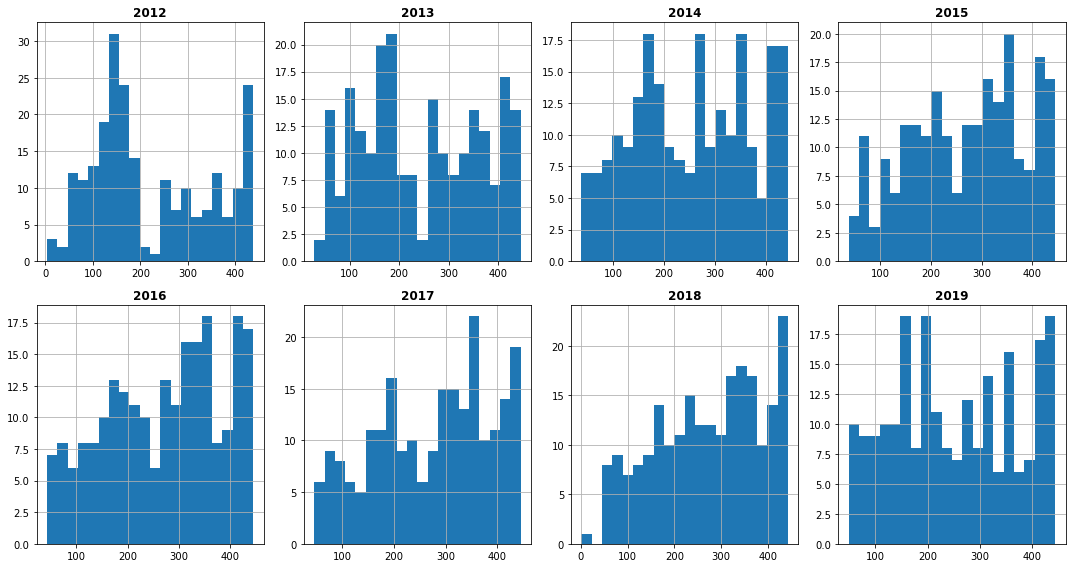

In [161]:
### Overall
fig, ax = plt.subplots(2,4, figsize=(15, 8))
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

ax = ax.ravel()
for i, a in enumerate(ax):
    pd.Series(dict(list_of_dirOG[i].degree()).values()).hist(bins=20, ax=a)
    a.set_title(f'{years[i]}', fontweight='bold')
plt.tight_layout()
plt.savefig('histograms.png', transparency=True, 
            bbox_inches='tight')
plt.show();

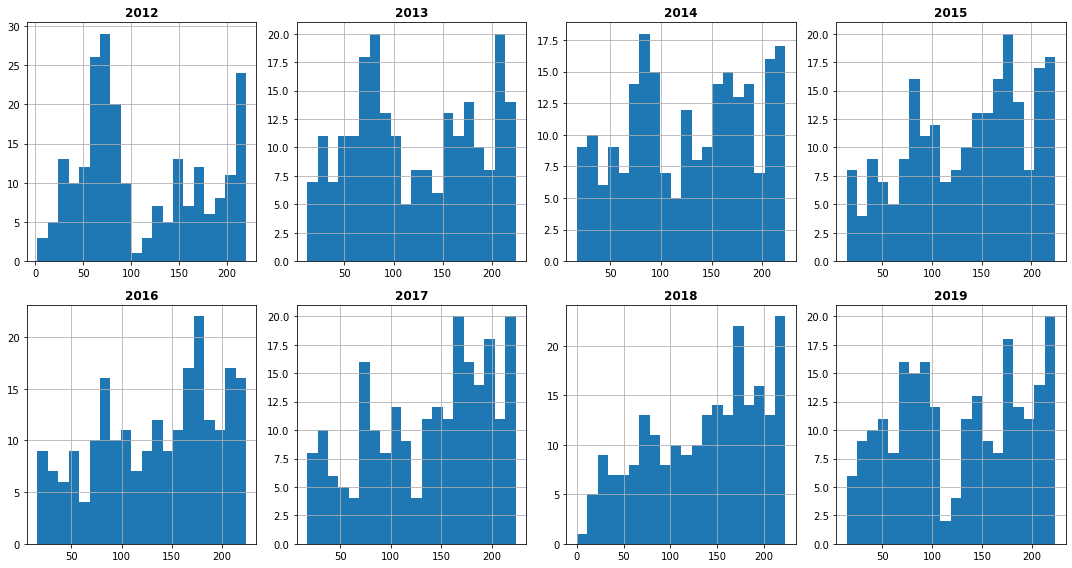

In [162]:
### In Degrees
fig, ax = plt.subplots(2,4, figsize=(15, 8))
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

ax = ax.ravel()
for i, a in enumerate(ax):
    pd.Series(dict(list_of_dirOG[i].in_degree()).values()).hist(bins=20, ax=a)
    a.set_title(f'{years[i]}', fontweight='bold')
plt.tight_layout()
plt.savefig('histograms.png', transparency=True, 
            bbox_inches='tight')
plt.show();

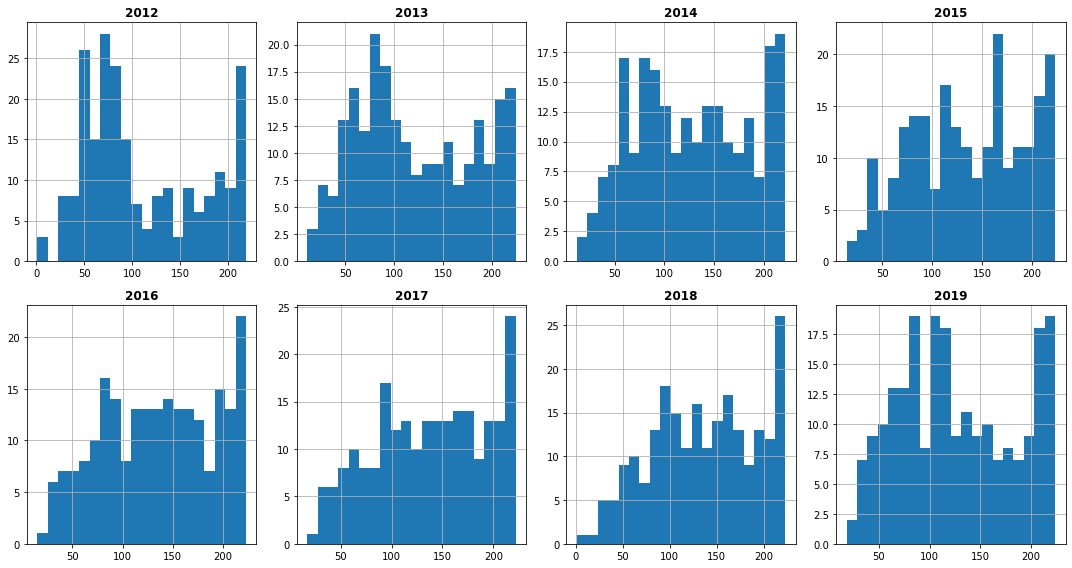

In [163]:
### Out Degrees
fig, ax = plt.subplots(2,4, figsize=(15, 8))
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

ax = ax.ravel()
for i, a in enumerate(ax):
    pd.Series(dict(list_of_dirOG[i].out_degree()).values()).hist(bins=20, ax=a)
    a.set_title(f'{years[i]}', fontweight='bold')
plt.tight_layout()
plt.savefig('histograms.png', transparency=True, 
            bbox_inches='tight')
plt.show();

## Top Importers as Hubs

In [146]:
df_hubs_in = pd.DataFrame()
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
for n in range(len(list_of_dirOG)):
    f = pd.DataFrame(sorted(dict(list_of_dirOG[n].in_degree()).items(), 
                            key=lambda x: x[1], reverse=True)[:10], 
                     columns=pd.MultiIndex
                     .from_tuples([(years[n],'country'), 
                                   (years[n],'degree')]))
    df_hubs_in = pd.concat([df_hubs_in, f], axis=1)

In [147]:
df_hubs_in

2012                   2013                  2014         \
         country degree         country degree        country degree   
0    Netherlands    220          France    224         France    223   
1         France    219         Belgium    222    Netherlands    222   
2         Mexico    218     Netherlands    222       Thailand    222   
3            USA    218         Czechia    220        Czechia    220   
4  Rep. of Korea    217        Thailand    219         Poland    219   
5         Poland    217          Poland    218          Spain    219   
6          Spain    217           Spain    218      Singapore    218   
7    Switzerland    217  United Kingdom    218  Rep. of Korea    217   
8       Thailand    216    South Africa    217   South Africa    217   
9        Czechia    215             USA    217            USA    217   

            2015                  2016                   2017         \
         country degree        country degree         country degree   
0         France    224         France    224          France    224   
1          Spain    222       Thailand    221         Czechia    223   
2        Czechia    221        Czechia    220          Poland    223   
3      Singapore    220  Rep. of Korea    220        Thailand    222   
4  Rep. of Korea    219      Singapore    220           Spain    221   
5    Netherlands    219         Poland    219   Rep. of Korea    219   
6       Thailand    219          Spain    219        Slovakia    219   
7         Poland    218       Slovakia    218    South Africa    219   
8       Slovenia    218    New Zealand    217  United Kingdom    218   
9   South Africa    218   South Africa    217         Ireland    217   

             2018                   2019         
          country degree         country degree  
0          France    223          France    223  
1         Czechia    222    South Africa    222  
2    South Africa    222         Belgium    221  
3          Poland    221         Czechia    221  
4        Thailand    221         Germany    221  
5         Belgium    220          Poland    221  
6   Rep. of Korea    220  United Kingdom    221  
7           Spain    220       Indonesia    220  
8  United Kingdom    220           Spain    220  
9     Netherlands    218   Rep. of Korea    219

## Top Exporters as Hubs

In [148]:
df_hubs_out = pd.DataFrame()
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
for n in range(len(list_of_dirOG)):
    f = pd.DataFrame(sorted(dict(list_of_dirOG[n].out_degree()).items(), 
                            key=lambda x: x[1], reverse=True)[:10], 
                     columns=pd.MultiIndex
                     .from_tuples([(years[n],'country'), 
                                   (years[n],'degree')]))
    df_hubs_out = pd.concat([df_hubs_out, f], axis=1)

In [149]:
df_hubs_out

2012                   2013                   2014         \
          country degree         country degree         country degree   
0             USA    219     Netherlands    224     Netherlands    222   
1         Belgium    218           Italy    223        Thailand    222   
2     Netherlands    218         Belgium    222         Belgium    221   
3         Germany    217          France    222          France    221   
4   Rep. of Korea    217  United Kingdom    221  United Kingdom    221   
5     Switzerland    217         Germany    220         Germany    220   
6  United Kingdom    217     Switzerland    220           Italy    219   
7        Thailand    216   Rep. of Korea    219     Switzerland    219   
8           Italy    215             USA    219           Spain    218   
9           Spain    215           Spain    218             USA    218   

             2015                   2016                   2017         \
          country degree         country degree         country degree   
0     Netherlands    223         Germany    223           Italy    222   
1         Germany    222     Netherlands    223  United Kingdom    222   
2        Thailand    222          France    221          France    221   
3          France    221           Spain    221     Netherlands    221   
4  United Kingdom    221          Sweden    221         Belgium    219   
5         Belgium    219           Italy    220           Spain    219   
6           Italy    219  United Kingdom    220          Sweden    219   
7             USA    219        Thailand    219        Thailand    219   
8        Malaysia    218             USA    219         Germany    218   
9         Denmark    217         Belgium    217     Switzerland    218   

             2018                   2019         
          country degree         country degree  
0     Netherlands    223           Italy    224  
1        Thailand    222         Germany    223  
2          Brazil    221     Netherlands    223  
3     Switzerland    221  United Kingdom    221  
4  United Kingdom    221          Brazil    220  
5         Germany    220         Belgium    219  
6          France    219           India    219  
7          Sweden    219           Spain    219  
8             USA    219          France    218  
9         Belgium    218             USA    218

## Network Representation of Export and Import

In [85]:
#und_2019 = nx.convert_matrix.from_pandas_edgelist(
#           data_dictio['Y2019'], source='exporter', target='importer', edge_attr=['hs_sec', 'value_kUSD', 
#                                                                    'quantity_mtons', 
#                                                                    'exp_coord', 'exp_coord'])

In [118]:
d_2019 = data_dictio['Y2019']

,year,exporter,importer,hscode,value_kUSD,quantity_mtons,hs_chap,section,hs_sec,exp_coord,imp_coord
0,2019,Afghanistan,Azerbaijan,70310,5.757,22.000,7,Vegetable products,2,"{'latitude': 33.7680065, 'longitude': 66.2385139}","{'latitude': 40.3936294, 'longitude': 47.7872508}"
1,2019,Afghanistan,Azerbaijan,80211,2.453,0.196,8,Vegetable products,2,"{'latitude': 33.7680065, 'longitude': 66.2385139}","{'latitude': 40.3936294, 'longitude': 47.7872508}"
2,2019,Afghanistan,Azerbaijan,80620,0.179,0.028,8,Vegetable products,2,"{'latitude': 33.7680065, 'longitude': 66.2385139}","{'latitude': 40.3936294, 'longitude': 47.7872508}"
3,2019,Afghanistan,Azerbaijan,80711,5.886,37.830,8,Vegetable products,2,"{'latitude': 33.7680065, 'longitude': 66.2385139}","{'latitude': 40.3936294, 'longitude': 47.7872508}"
4,2019,Afghanistan,Azerbaijan,81310,0.115,0.014,8,Vegetable products,2,"{'latitude': 33.7680065, 'longitude': 66.2385139}","{'latitude': 40.3936294, 'longitude': 47.7872508}"
...,...,...,...,...,...,...,...,...,...,...,...
10646204,2019,Zambia,Burkina Faso,100510,0.194,0.040,10,Vegetable products,2,"{'latitude': -14.5189121, 'longitude': 27.5589...","{'latitude': 12.0753083, 'longitude': -1.6880314}"
10646205,2019,Zambia,Burkina Faso,392510,52.570,7.000,39,"Plastics, rubber, articles thereof",7,"{'latitude': -14.5189121, 'longitude': 27.5589...","{'latitude': 12.0753083, 'longitude': -1.6880314}"
10646206,2019,Zambia,Burkina Faso,722830,23.721,1.218,72,Base metals and articles of base metal,15,"{'latitude': -14.5189121, 'longitude': 27.5589...","{'latitude': 12.0753083, 'longitude': -1.6880314}"
10646207,2019,Zambia,Burkina Faso,722880,20.259,2.887,72,Base metals and articles of base metal,15,"{'latitude': -14.5189121, 'longitude': 27.5589...","{'latitude': 12.0753083, 'longitude': -1.6880314}"


In [ ]:
vals_2019 = (
    data_dictio['Y2019']
    .groupby(['exporter', 'importer'])['value_kUSD']
    .sum()
    .reset_index())

In [ ]:
OG_2019 = nx.from_pandas_edgelist(
          vals_2019, source='exporter', target='importer', 
          create_using=nx.DiGraph(), edge_attr=['value_kUSD'])

In [127]:
und_2019 = OG_2019

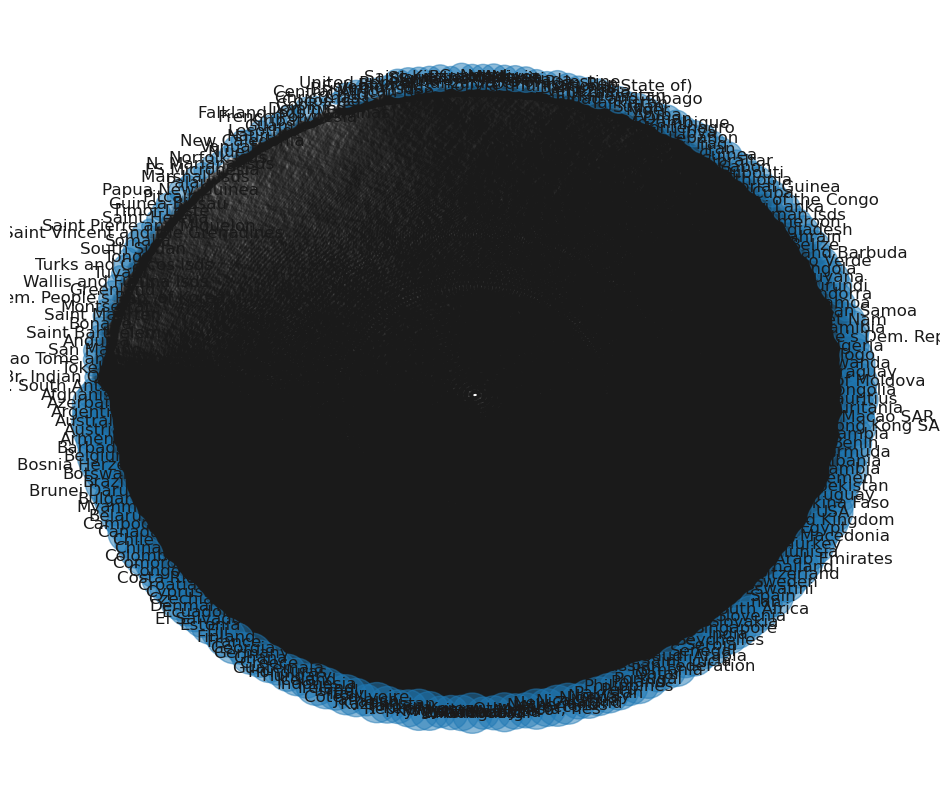

In [130]:
pos = nx.shell_layout(und_2019)

plt.figure(figsize=(12, 10))

nodelist = [item[0] for item in und_2019.in_degree()]
node_size = [1+4*item[1] for item in und_2019.in_degree()]


nx.draw_networkx_nodes(
    und_2019,
    pos,
    nodelist=nodelist,
    node_size=node_size, 
    alpha=0.5,
    cmap='brg'
)

nx.draw_networkx_edges(und_2019, pos, edge_color='k', alpha=0.1)
nx.draw_networkx_labels(und_2019, pos)

#plt.xlabel('Figure 1: Network Diagram of Social Network')
#plt.title("Social Network", fontweight='black')
plt.axis('off')
plt.show();

## Scatter Plot of: x-degrees, size-qty of import/export, y-cost

In [138]:
deg_in = pd.DataFrame.from_dict(dict(und_2019.in_degree()), orient='index', columns=['in_deg'])
deg_out = pd.DataFrame.from_dict(dict(und_2019.out_degree()), orient='index', columns=['out_deg'])
deg = pd.concat([deg_in, deg_out], axis=1)

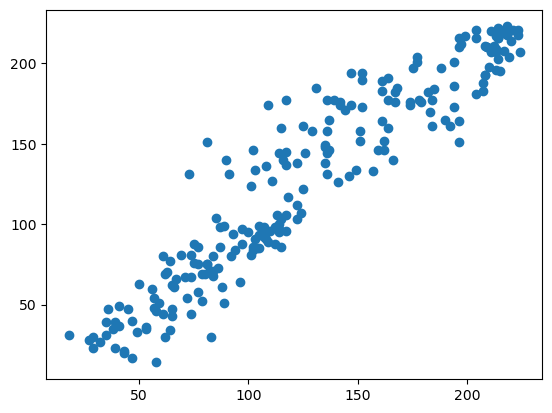

In [145]:
plt.scatter(deg['out_deg'], deg['in_deg'])